Here, we create a multiclass classifier for classifying the various closest vectors returned by the model, as the corresponding attributes.

In [162]:
import warnings
warnings.filterwarnings('ignore')

from gensim.models.wrappers import FastText
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import pandas as pd
import numpy as np
import h5py
from sklearn.model_selection import train_test_split

from keras.preprocessing import sequence
from keras import models
from keras import layers
from keras import activations
from keras import optimizers
from keras import losses
from keras import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

## Prepare Dataset

Read the data

In [163]:
df = pd.read_csv('amazonCleaned.csv', encoding='utf8')

In [164]:
df.head()

,Name,Author,Format,Publisher,Publishing Date
0,Age of Myth: Book One of The Legends of the Fi...,Michael J. Sullivan,Paperback,Del Rey,"January 31, 2017"
1,Rise of the Dragons (Kings and Sorcerers--Book 1),Morgan Rice,Hardcover,Morgan Rice,"August 4, 2017"
2,The Book of Deacon (Volume 1),Joseph Lallo,Kindle,CreateSpace Independent Publishing Platform,"March 18, 2012"
3,A Quest of Heroes: Book #1 in the Sorcerer's Ring,Morgan Rice,Hardcover,Morgan Rice,"December 3, 2012"
4,Fantasia: An Algerian Cavalcade,Dorothy S. Blair,Kindle,Heinemann; 1 edition,"March 15, 1993"


In [165]:
len(df)

7604

In [166]:
df.columns.values

array(['Name', 'Author', 'Format', 'Publisher', 'Publishing Date'],
      dtype=object)

In [167]:
names = df['Name'].tolist()
authors = df['Author'].tolist()
formats = df['Format'].tolist()
publishers = df['Publisher'].tolist()
publishingDate = df['Publishing Date'].tolist()

In [168]:
values = [names, authors, formats, publishers, publishingDate]
attributes = ['Name', 'Author', 'Format', 'Publisher', 'Publishing Date']

Create value, attribute-name tuple pairs

In [169]:
data = []
for i in range(len(values)):
    for value in values[i]:
        data.append([value, attributes[i]])

In [170]:
len(data)

38020

In [171]:
data[:10]

[['Age of Myth: Book One of The Legends of the First Empire', 'Name'],
 ['Rise of the Dragons (Kings and Sorcerers--Book 1)', 'Name'],
 ['The Book of Deacon (Volume 1)', 'Name'],
 ["A Quest of Heroes: Book #1 in the Sorcerer's Ring", 'Name'],
 ['Fantasia: An Algerian Cavalcade', 'Name'],
 ['The Fantasy Baseball Black Book 2018 (Fantasy Black Book)', 'Name'],
 ['Fantasy Baseball for Smart People: How to Use Math and Psychology to Win at DFS',
  'Name'],
 ['Final Fantasy XV Guide: Walkthrough, Side Quests, Bounty Hunts, Food Recipes, Cheats, Secrets and More',
  'Name'],
 ['Power, Faith, and Fantasy: America in the Middle East: 1776 to the Present',
  'Name'],
 ['Fantasy Flower Garden: Adult Coloring Book of Fantastic Flowers and Friendly Animals',
  'Name']]

In [172]:
data[-10:]

[['July 27, 1993', 'Publishing Date'],
 ['September 23, 2014', 'Publishing Date'],
 ['July 26, 2011', 'Publishing Date'],
 ['November 10, 2015', 'Publishing Date'],
 ['September 01, 2003', 'Publishing Date'],
 ['February 05, 2015', 'Publishing Date'],
 ['December 11, 1989', 'Publishing Date'],
 ['November 15, 2004', 'Publishing Date'],
 ['April 29, 2016', 'Publishing Date'],
 ['April 01, 2013', 'Publishing Date']]

In [173]:
dfData = pd.DataFrame(data, columns=['Value','Label'])

In [175]:
dfData.head()

,Value,Label
0,Age of Myth: Book One of The Legends of the Fi...,Name
1,Rise of the Dragons (Kings and Sorcerers--Book 1),Name
2,The Book of Deacon (Volume 1),Name
3,A Quest of Heroes: Book #1 in the Sorcerer's Ring,Name
4,Fantasia: An Algerian Cavalcade,Name


In [176]:
dfData.tail()

,Value,Label
38015,"February 05, 2015",Publishing Date
38016,"December 11, 1989",Publishing Date
38017,"November 15, 2004",Publishing Date
38018,"April 29, 2016",Publishing Date
38019,"April 01, 2013",Publishing Date


Convert labels to categorical attributes

In [177]:
dfData['Label'] = dfData['Label'].astype('category')

In [178]:
dfData["Label_Cat"] = dfData["Label"].cat.codes

In [179]:
dfData.tail()

,Value,Label,Label_Cat
38015,"February 05, 2015",Publishing Date,4
38016,"December 11, 1989",Publishing Date,4
38017,"November 15, 2004",Publishing Date,4
38018,"April 29, 2016",Publishing Date,4
38019,"April 01, 2013",Publishing Date,4


In [180]:
dfData['Label_Cat'].value_counts()

4    7604
3    7604
2    7604
1    7604
0    7604
Name: Label_Cat, dtype: int64

Get the mapping

In [181]:
mapping = dict(enumerate(dfData['Label'].cat.categories))

In [182]:
mapping

{0: 'Author', 1: 'Format', 2: 'Name', 3: 'Publisher', 4: 'Publishing Date'}

Drop the Label column

In [183]:
dfData.drop(['Label'], axis=1, inplace=True)

In [184]:
dfData.head()

,Value,Label_Cat
0,Age of Myth: Book One of The Legends of the Fi...,2
1,Rise of the Dragons (Kings and Sorcerers--Book 1),2
2,The Book of Deacon (Volume 1),2
3,A Quest of Heroes: Book #1 in the Sorcerer's Ring,2
4,Fantasia: An Algerian Cavalcade,2


Shuffle the data

In [185]:
dfData = dfData.sample(frac=1).reset_index(drop=True)

In [186]:
dfData.head(10)

,Value,Label_Cat
0,Jack M. Bickham,0
1,"April 01, 1989",4
2,Harper Voyager,3
3,"September 11, 2012",4
4,"June 21, 2016",4
5,Berkley; 1st edition,3
6,The Legacy of Shadows,2
7,"September 11, 1996",4
8,"March 27, 2015",4
9,Piero Camporesi,0


Find the longest string in the value column

In [187]:
dfData.Value.map(lambda x: len(x)).max()

289

In [188]:
X = dfData['Value'].tolist()
y = dfData['Label_Cat'].tolist()

## Tokenize and obtain the train, test split

In [189]:
batchSize = 32
maxSequenceLength = 300
maxWords = 25000

In [190]:
tokenizer = Tokenizer(num_words=maxWords)

In [191]:
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

In [192]:
print('Found %s unique tokens.' % len(word_index))

Found 14292 unique tokens.


In [193]:
data = pad_sequences(sequences, maxlen=maxSequenceLength)

In [194]:
labels = np.asarray(y)

In [195]:
data.shape

(38020, 300)

In [196]:
labels.shape

(38020,)

In [207]:
labels = to_categorical(labels)

In [208]:
labels.shape

(38020, 5)

Shuffle the dataset

In [209]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

In [210]:
data = data[indices]
labels = labels[indices]

Train test split

In [211]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [212]:
len(X_train), len(y_train)

(30416, 30416)

In [213]:
len(X_test), len(y_test)

(7604, 7604)

## Model

In [214]:
embeddingDim = 100

**Architecture**
* 1 embedding layer 
* 1 dense layer, 32 hidden units and _relu_ activation
* 1 dense layer, 64 hidden units and _relu_ activation
* 1 output layer, _softmax_ activation

In [220]:
model = models.Sequential()
model.add(layers.Embedding(maxWords, embeddingDim, input_length=maxSequenceLength))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation=activations.relu))
model.add(layers.Dense(64, activation=activations.relu))
model.add(layers.Dense(5, activation=activations.softmax))

model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss=losses.categorical_crossentropy, metrics=['accuracy'])

In [221]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 100)          2500000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                960032    
_________________________________________________________________
dense_11 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 325       
Total params: 3,462,469
Trainable params: 3,462,469
Non-trainable params: 0
_________________________________________________________________


In [222]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32, 
                    validation_split=0.2)

Train on 24332 samples, validate on 6084 samples
Epoch 1/10
24332/24332 [==============================] - 16s 645us/step - loss: 1.1665 - acc: 0.4476 - val_loss: 0.6974 - val_acc: 0.5736
Epoch 2/10
24332/24332 [==============================] - 12s 490us/step - loss: 0.2864 - acc: 0.8976 - val_loss: 0.1983 - val_acc: 0.9265
Epoch 3/10
24332/24332 [==============================] - 12s 495us/step - loss: 0.1168 - acc: 0.9681 - val_loss: 0.1431 - val_acc: 0.9630
Epoch 4/10
24332/24332 [==============================] - 12s 489us/step - loss: 0.0911 - acc: 0.9773 - val_loss: 0.1512 - val_acc: 0.9610
Epoch 5/10
24332/24332 [==============================] - 12s 496us/step - loss: 0.0764 - acc: 0.9815 - val_loss: 0.1660 - val_acc: 0.9507
Epoch 6/10
24332/24332 [==============================] - 12s 496us/step - loss: 0.0659 - acc: 0.9850 - val_loss: 0.1474 - val_acc: 0.9610
Epoch 7/10
24332/24332 [==============================] - 12s 491us/step - loss: 0.0584 - acc: 0.9866 - val_loss: 0.1

In [224]:
history.history.keys()

dict_keys(['val_loss', 'loss', 'val_acc', 'acc'])

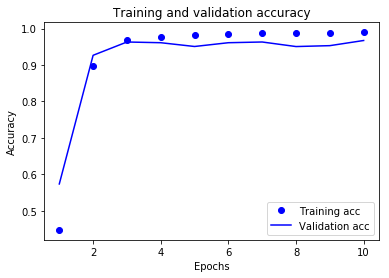

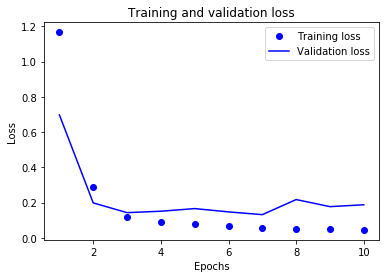

In [225]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

Test on testing set

In [226]:
results = model.evaluate(X_test, y_test)

7604/7604 [==============================] - 2s 204us/step


In [228]:
loss = results[0]
accuracy = results[1]

In [229]:
loss

0.17456323602785048

In [230]:
accuracy

0.9685691740875304

** Test Set Accuracy: 96.85% **

Save the model

In [231]:
model.save("AmazonClassifier.h5")